In [136]:
# 导入需要用到的package
import numpy as np
import json
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')
data

array([6.320e-03, 1.800e+01, 2.310e+00, ..., 3.969e+02, 7.880e+00,
       1.190e+01])

### 2.1.2 数据形状变换

由于读入的原始数据是1维的，所有数据都连在一起。因此需要我们将数据的形状进行变换，形成一个2维的矩阵，每行为一个数据样本（14个值），每个数据样本包含13个XXX（影响房价的特征）和一个YYY（该类型房屋的均价）。

In [137]:
# 读入之后的数据被转化成1维array，其中array的第0-13项是第一条数据，第14-27项是第二条数据，以此类推.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])
data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 3.9690e+02, 4.9800e+00,
        2.4000e+01],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 3.9690e+02, 9.1400e+00,
        2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 3.9283e+02, 4.0300e+00,
        3.4700e+01],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 5.6400e+00,
        2.3900e+01],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 3.9345e+02, 6.4800e+00,
        2.2000e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 7.8800e+00,
        1.1900e+01]])

In [138]:
# 查看数据
x = data[0]
print(x.shape)
print(x,len(data))  

(14,)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01] 506


### 2.1.3 数据集划分

将数据集划分成训练集和测试集，其中训练集用于确定模型的参数，测试集用于评判模型的效果。为什么要对数据集进行拆分，而不能直接应用于模型训练呢？这与学生时代的授课和考试关系比较类似，如 图4 所示。

图4：训练集和测试集拆分的意义

上学时总有一些自作聪明的同学，平时不认真学习，考试前临阵抱佛脚，将习题死记硬背下来，但是成绩往往并不好。因为学校期望学生掌握的是知识，而不仅仅是习题本身。另出新的考题，才能鼓励学生努力去掌握习题背后的原理。同样我们期望模型学习的是任务的本质规律，而不是训练数据本身，模型训练未使用的数据，才能更真实的评估模型的效果。

在本案例中，我们将80%的数据用作训练集，20%用作测试集，实现代码如下。通过打印训练集的形状，可以发现共有404个样本，每个样本含有13个特征和1个预测值。

In [139]:
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
training_data.shape
training_data

array([[6.32000e-03, 1.80000e+01, 2.31000e+00, ..., 3.96900e+02,
        4.98000e+00, 2.40000e+01],
       [2.73100e-02, 0.00000e+00, 7.07000e+00, ..., 3.96900e+02,
        9.14000e+00, 2.16000e+01],
       [2.72900e-02, 0.00000e+00, 7.07000e+00, ..., 3.92830e+02,
        4.03000e+00, 3.47000e+01],
       ...,
       [1.42362e+01, 0.00000e+00, 1.81000e+01, ..., 3.96900e+02,
        2.03200e+01, 7.20000e+00],
       [9.59571e+00, 0.00000e+00, 1.81000e+01, ..., 3.76110e+02,
        2.03100e+01, 1.21000e+01],
       [2.48017e+01, 0.00000e+00, 1.81000e+01, ..., 3.96900e+02,
        1.97700e+01, 8.30000e+00]])

####  2.1.4 数据归一化处理

对每个特征进行归一化处理，使得每个特征的取值缩放到0~1之间。这样做有两个好处：一是模型训练更高效，在本节的后半部分会详细说明；二是特征前的权重大小可以代表该变量对预测结果的贡献度（因为每个特征值本身的范围相同）。

In [140]:
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

####  2.1.5 封装成load data函数

将上述几个数据处理操作封装成`load data`函数，以便下一步模型的调用，实现方法如下。

In [141]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [142]:
# 获取数据
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

# 查看数据
print(x[0])
print(y[0])
print(training_data[:,:])

[0.         0.18       0.07344184 0.         0.31481481 0.57750527
 0.64160659 0.26920314 0.         0.22755741 0.28723404 1.
 0.08967991]
[0.42222222]
[[0.00000000e+00 1.80000000e-01 7.34418420e-02 ... 1.00000000e+00
  8.96799117e-02 4.22222222e-01]
 [2.35922539e-04 0.00000000e+00 2.62405717e-01 ... 1.00000000e+00
  2.04470199e-01 3.68888889e-01]
 [2.35697744e-04 0.00000000e+00 2.62405717e-01 ... 9.87519166e-01
  6.34657837e-02 6.60000000e-01]
 ...
 [1.59940420e-01 0.00000000e+00 7.00277888e-01 ... 1.00000000e+00
  5.12969095e-01 4.88888889e-02]
 [1.07782432e-01 0.00000000e+00 7.00277888e-01 ... 9.36246550e-01
  5.12693157e-01 1.57777778e-01]
 [2.78694093e-01 0.00000000e+00 7.00277888e-01 ... 1.00000000e+00
  4.97792494e-01 7.33333333e-02]]


### 2.2 模型设计

模型设计是深度学习模型关键要素之一，也称为网络结构设计，相当于模型的假设空间，即实现模型“前向计算”（从输入到输出）的过程。

如果将输入特征和输出预测值均以向量表示，输入特征$x$有13个分量，$y$有1个分量，那么参数权重的形状（shape）是$13\times1$。假设我们以如下任意数字赋值参数做初始化：
$$w=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3, -0.4, 0.0]$$

In [143]:
w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3, -0.4, 0.0]
w = np.array(w).reshape([13, 1])

In [144]:
# 取出第1条样本数据，观察样本的特征向量与参数向量相乘的结果。
x1=x[0]
t = np.dot(x1, w)
print(t)


[0.69474855]


In [145]:
#完整的线性回归公式，还需要初始化偏移量$b$，同样随意赋初值-0.2。那么，线性回归模型的完整输出是$z=t+b$，这个从特征和参数计算输出值的过程称为“前向计算”。
b = -0.2
z = t + b
print(z)

[0.49474855]


In [146]:
#将上述计算预测输出的过程以“类和对象”的方式来描述，类成员变量有参数$w$和$b$。通过写一个`forward`函数（代表“前向计算”）
#完成上述从特征和参数到输出预测值的计算过程，代码如下所示。
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

In [147]:
# 基于Network类的定义，模型的计算过程如下所示。
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[2.39362982]


In [148]:
# 从上述前向计算的过程可见，线性回归也可以表示成一种简单的神经网络（只有一个神经元，且激活函数为恒等式）。这也是机器学习模型普遍为
# 深度学习模型替代的原因：由于深度学习网络强大的表示能力，很多传统机器学习模型的学习能力等同于相对简单的深度学习模型。

### 2.3 训练配置

模型设计完成后，需要通过训练配置寻找模型的最优值，即通过损失函数来衡量模型的好坏。训练配置也是深度学习模型关键要素之一。

通过模型计算$x_1$表示的影响因素所对应的房价应该是$z$, 但实际数据告诉我们房价是$y$。这时我们需要有某种指标来衡量预测值$z$跟真实值$y$之间的差距。对于回归问题，最常采用的衡量方法是使用均方误差作为评价模型好坏的指标，具体定义如下：

$$Loss = (y - z)^2 (公式3)$$

上式中的$Loss$（简记为: $L$）通常也被称作损失函数，它是衡量模型好坏的指标。读者可能会奇怪：如果要衡量预测房价和真实房价之间的差距，是否将每一个样本的差距的绝对值加和即可？差距绝对值加和是更加直观和朴素的思路，为何要平方加和？ 损失函数的设计不仅要考虑准确衡量问题的“合理性”，通常还要考虑“易于优化求解”。至于这个问题的答案，在介绍完优化算法后再揭示。

在回归问题中，均方误差是一种比较常见的形式，分类问题中通常会采用交叉熵作为损失函数，在后续的章节中会更详细的介绍。对一个样本计算损失函数值的实现如下。

In [149]:
Loss = (y1 - z)*(y1 - z)
print(Loss)

[3.88644793]


因为计算损失函数时需要把每个样本的损失函数值都考虑到，所以我们需要对单个样本的损失函数进行求和，并除以样本总数$N$。
$$L= \frac{1}{N}\sum_{i=1}^N{(y_i - z_i)^2}$$
在Network类下面添加损失函数的计算过程如下。

In [150]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost

In [151]:
# 使用定义的Network类，可以方便的计算预测值和损失函数。需要注意的是，类中的变量$x$, $w$，$b$, $z$, $error$等均是向量。以变量$x$为例，
# 共有两个维度，一个代表特征数量（值为13），一个代表样本数量，代码如下所示。

### 2.4 训练过程

上述计算过程描述了如何构建神经网络，通过神经网络完成预测值和损失函数的计算。接下来介绍如何求解参数$w$和$b$的数值，这个过程也称为模型训练过程。训练过程是深度学习模型的关键要素之一，其目标是让定义的损失函数$Loss$尽可能的小，也就是说找到一个参数解$w$和$b$，使得损失函数取得极小值。

我们先做一个小测试：如 **图5** 所示，基于微积分知识，求一条曲线在某个点的斜率等于函数在该点的导数值。那么大家思考下，当处于曲线的极值点时，该点的斜率是多少？

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/94f0437e6a454a0682f3b831c96a62bdaf40898af25145ec9b5b50bc80391f5c" width="300" hegiht="" ></center>
<center><br>图5：曲线斜率等于导数值</br></center>
<br></br>

这个问题并不难回答，处于曲线极值点时的斜率为0，即函数在极值点的导数为0。那么，让损失函数取极小值的$w$和$b$应该是下述方程组的解：
$$\frac{\partial{L}}{\partial{\boldsymbol{w}}}=0,(公式5)$$
$$\frac{\partial{L}}{\partial{b}}=0,(公式6)$$

其中$L$表示的是损失函数的值，$\boldsymbol{w}$为模型权重，$b$为偏置项。$\boldsymbol{w}$和$b$均为要学习的模型参数。

把损失函数表示成矩阵的形式为

$$
L=\frac{1}{N}||\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}+\boldsymbol{b})||^2, (公式7)
$$

其中$\boldsymbol{y}$为$N$个样本的标签值构成的向量，形状为$N\times 1$；$\boldsymbol{X}$为$N$个样本特征向量构成的矩阵，形状为$N\times D$，$D$为数据特征长度；$\boldsymbol{w}$为权重向量，形状为$D\times 1$；$\boldsymbol{b}$为所有元素都为$b$的向量，形状为$N\times 1$。

计算公式7对参数$b$的偏导数
$$
\frac{\partial L}{\partial b} = \boldsymbol{1}^T(\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}+\boldsymbol{b})), (公式8)
$$
请注意，上述公式忽略了系数$\frac{2}{N}$，并不影响最后结果。其中$\boldsymbol{1}$为$N$维的全1向量。

令公式8等于0，得到
$$
b^* = \boldsymbol{\bar{x}}^T\boldsymbol{w}-\bar{y}(公式9)
$$
其中$\bar{y}=\frac{1}{N}\boldsymbol{1}^T\boldsymbol{y}$为所有标签的平均值，$\boldsymbol{\bar{x}}=\frac{1}{N}(\boldsymbol{1}^T\boldsymbol{X})^T$为所有特征向量的平均值。将$b^*$带入公式7中并对参数$\boldsymbol{w}$求偏导得到

$$
\frac{\partial L}{\partial \boldsymbol{w}} = (\boldsymbol{X}-\boldsymbol{\bar{x}}^T)^T((\boldsymbol{y}-\bar{y})-(\boldsymbol{X}-\boldsymbol{\bar{x}}^T)\boldsymbol{w}) (公式10)
$$

令公式10等于0，得到最优参数

$$
\boldsymbol{w}^*=((\boldsymbol{X}-\boldsymbol{\bar{x}}^T)^T(\boldsymbol{X}-\boldsymbol{\bar{x}}^T))^{-1}(\boldsymbol{X}-\boldsymbol{\bar{x}}^T)^T(\boldsymbol{y}-\bar{y})(公式11) \\
b^* = \boldsymbol{\bar{x}}^T\boldsymbol{w}^*-\bar{y}(公式12)
$$


将样本数据$(x, y)$带入上面的公式11和公式12中即可求解出$w$和$b$的值，但是这种方法只对线性回归这样简单的任务有效。如果模型中含有非线性变换，或者损失函数不是均方差这种简单的形式，则很难通过上式求解。为了解决这个问题，下面我们将引入更加普适的数值求解方法：梯度下降法。

#### 2.4.1 梯度下降法

在现实中存在大量的函数正向求解容易，但反向求解较难，被称为单向函数，这种函数在密码学中有大量的应用。密码锁的特点是可以迅速判断一个密钥是否是正确的(已知$x$，求$y$很容易)，但是即使获取到密码锁系统，也无法破解出正确得密钥（已知$y$，求$x$很难）。

这种情况特别类似于一位想从山峰走到坡谷的盲人，他看不见坡谷在哪（无法逆向求解出$Loss$导数为0时的参数值），但可以伸脚探索身边的坡度（当前点的导数值，也称为梯度）。那么，求解Loss函数最小值可以这样实现：从当前的参数取值，一步步的按照下坡的方向下降，直到走到最低点。这种方法笔者称它为“盲人下坡法”。哦不，有个更正式的说法“梯度下降法”。

训练的关键是找到一组$(w, b)$，使得损失函数$L$取极小值。我们先看一下损失函数$L$只随两个参数$w_5$、$w_9$变化时的简单情形，启发下寻解的思路。
$$L=L(w_5, w_9) (公式13)$$
这里将$w_0, w_1, ..., w_{12}$中除$w_5, w_9$之外的参数和$b$都固定下来，可以用图画出$L(w_5, w_9)$的形式，并在三维空间中画出损失函数随参数变化的曲面图。

In [152]:
net = Network(13)
losses = []
#只画出参数w5和w9在区间[-160, 160]的曲线部分，以及包含损失函数的极值
w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)
losses = np.zeros([len(w5), len(w9)])

#计算设定区域内每个参数取值所对应的Loss
for i in range(len(w5)):
    for j in range(len(w9)):
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        z = net.forward(x)
        loss = net.loss(z, y)
        losses[i, j] = loss

#使用matplotlib将两个变量和对应的Loss作3D图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

w5, w9 = np.meshgrid(w5, w9)
ax.plot_surface(w5, w9, losses, rstride=1, cstride=1, cmap='rainbow')
plt.show()

<Figure size 640x480 with 0 Axes>

从图中可以明显观察到有些区域的函数值比周围的点小。需要说明的是：为什么选择$w_5$和$w_9$来画图呢？这是因为选择这两个参数的时候，可比较直观的从损失函数的曲面图上发现极值点的存在。其他参数组合，从图形上观测损失函数的极值点不够直观。

观察上述曲线呈现出“圆滑”的坡度，这正是我们选择以均方误差作为损失函数的原因之一。**图6** 呈现了只有一个参数维度时，均方误差和绝对值误差（只将每个样本的误差累加，不做平方处理）的损失函数曲线图。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/99487dca6520441db5073d1c154b5d2fb1174b5cf4d946c29f9d80a209bc2687" width="700" hegiht="40" ></center>
<center><br>图6：均方误差和绝对值误差损失函数曲线图</br></center>
<br></br>

由此可见，均方误差表现的“圆滑”的坡度有两个好处：

* 曲线的最低点是可导的。
* 越接近最低点，曲线的坡度逐渐放缓，有助于通过当前的梯度来判断接近最低点的程度（是否逐渐减少步长，以免错过最低点）。

而绝对值误差是不具备这两个特性的，这也是损失函数的设计不仅仅要考虑“合理性”，还要追求“易解性”的原因。

现在我们要找出一组$[w_5, w_9]$的值，使得损失函数最小，实现梯度下降法的方案如下：

- 步骤1：随机的选一组初始值，例如：$[w_5, w_9] = [-100.0, -100.0]$
- 步骤2：选取下一个点$[w_5^{'} , w_9^{'}]$，使得$L(w_5^{'} , w_9^{'}) < L(w_5, w_9)$
- 步骤3：重复步骤2，直到损失函数几乎不再下降。

如何选择$[w_5^{'} , w_9^{'}]$是至关重要的，第一要保证$L$是下降的，第二要使得下降的趋势尽可能的快。微积分的基础知识告诉我们：沿着梯度的反方向，是函数值下降最快的方向，如 **图7** 所示。简单理解，函数在某一个点的梯度方向是曲线斜率最大的方向，但梯度方向是向上的，所以下降最快的是梯度的反方向。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/5f8322f6172542dab0f78684b70efe45d819895332af4cabb7c536217ab0bb26" width="400" hegiht="40" ></center>
<center><br>图7：梯度下降方向示意图</br></center>
<br></br>


#### 2.4.2 梯度计算

上文已经介绍了损失函数的计算方法，这里稍微改写。为了使梯度计算更加简洁，引入因子$\frac{1}{2}$，定义损失函数如下：

$$L= \frac{1}{2N}\sum_{i=1}^N{(y_i - z_i)^2} (公式14)$$

其中$z_i$是网络对第$i$个样本的预测值：

$$z_i = \sum_{j=0}^{12}{x_i^{j}\cdot w_j} + b (公式15)$$

梯度的定义：

$$𝑔𝑟𝑎𝑑𝑖𝑒𝑛𝑡 = (\frac{\partial{L}}{\partial{w_0}},\frac{\partial{L}}{\partial{w_1}}, ... ,\frac{\partial{L}}{\partial{w_{12}}} ,\frac{\partial{L}}{\partial{b}}) (公式16)$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{w_j}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)x_i^{j}} (公式17)$$

$$\frac{\partial{L}}{\partial{b}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{b}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)} (公式18)$$

从导数的计算过程可以看出，因子$\frac{1}{2}$被消掉了，这是因为二次函数求导的时候会产生因子$2$，这也是我们将损失函数改写的原因。

下面我们考虑只有一个样本的情况下，计算梯度：

$$L= \frac{1}{2}{(y_i - z_i)^2} (公式19)$$

$$z_1 = {x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b (公式20)$$

可以计算出：

$$L= \frac{1}{2}{({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b - y_1)^2} (公式21)$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_0}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_12} + b - y_1)\cdot x_1^{0}=({z_1} - {y_1})\cdot x_1^{0} (公式22)$$

$$\frac{\partial{L}}{\partial{b}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b - y_1)\cdot 1 = ({z_1} - {y_1}) (公式23)$$

In [153]:
# 可以通过具体的程序查看每个变量的数据和维度。
x1 = x[0]
y1 = y[0]
z1 = net.forward(x1)
print('x1 {}, shape {}'.format(x1, x1.shape))
print('y1 {}, shape {}'.format(y1, y1.shape))
print('z1 {}, shape {}'.format(z1, z1.shape))

# 按上面的公式，当只有一个样本时，可以计算某个$w_j$，比如$w_0$的梯度。
gradient_w0 = (z1 - y1) * x1[0]
print('gradient_w0 {}'.format(gradient_w0))

# 同样我们可以计算$w_1$的梯度。
gradient_w1 = (z1 - y1) * x1[1]
print('gradient_w1 {}'.format(gradient_w1))

#依次计算$w_2$的梯度。
gradient_w2= (z1 - y1) * x1[2]
print('gradient_w1 {}'.format(gradient_w2))

#聪明的读者可能已经想到，写一个for循环即可计算从$w_0$到$w_{12}$的所有权重的梯度，该方法读者可以自行实现。

x1 [0.         0.18       0.07344184 0.         0.31481481 0.57750527
 0.64160659 0.26920314 0.         0.22755741 0.28723404 1.
 0.08967991], shape (13,)
y1 [0.42222222], shape (1,)
z1 [130.86954441], shape (1,)
gradient_w0 [0.]
gradient_w1 [23.48051799]
gradient_w1 [9.58029163]


#### 2.4.3 使用NumPy进行梯度计算

基于NumPy广播机制（对向量和矩阵计算如同对1个单一变量计算一样），可以更快速的实现梯度计算。计算梯度的代码中直接用$(z_1 - y_1) \cdot x_1$，得到的是一个13维的向量，每个分量分别代表该维度的梯度。

In [154]:
gradient_w = (z1 - y1) * x1
print('gradient_w_by_sample1 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample1 [  0.          23.48051799   9.58029163   0.          41.06674958
  75.33401592  83.69586171  35.11682862   0.          29.68425495
  37.46891169 130.44732219  11.69850434], gradient.shape (13,)


In [155]:
# 输入数据中有多个样本，每个样本都对梯度有贡献。如上代码计算了只有样本1时的梯度值，同样的计算方法也可以计算样本2和样本3对梯度的贡献。
x2 = x[1]
y2 = y[1]
z2 = net.forward(x2)
gradient_w = (z2 - y2) * x2
print('gradient_w_by_sample2 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample2 [2.54738434e-02 0.00000000e+00 2.83333765e+01 0.00000000e+00
 1.86624242e+01 5.91703008e+01 8.45121992e+01 3.76793284e+01
 4.69458498e+00 1.23980167e+01 5.97311025e+01 1.07975454e+02
 2.20777626e+01], gradient.shape (13,)


此处可见，计算梯度`gradient_w`的维度是$3 \times 13$，并且其第1行与上面第1个样本计算的梯度gradient_w_by_sample1一致，第2行与上面第2个样本计算的梯度gradient_w_by_sample2一致，第3行与上面第3个样本计算的梯度gradient_w_by_sample3一致。这里使用矩阵操作，可以更加方便的对3个样本分别计算各自对梯度的贡献。

那么对于有N个样本的情形，我们可以直接使用如下方式计算出所有样本对梯度的贡献，这就是使用NumPy库广播功能带来的便捷。
小结一下这里使用NumPy库的广播功能：
- 一方面可以扩展参数的维度，代替for循环来计算1个样本对从$w_0$到$w_12$的所有参数的梯度。
- 另一方面可以扩展样本的维度，代替for循环来计算样本0到样本403对参数的梯度。

In [156]:
z = net.forward(x)
gradient_w = (z - y) * x
print('gradient_w shape {}'.format(gradient_w.shape))
print(gradient_w)

gradient_w shape (404, 13)
[[0.00000000e+00 2.34805180e+01 9.58029163e+00 ... 3.74689117e+01
  1.30447322e+02 1.16985043e+01]
 [2.54738434e-02 0.00000000e+00 2.83333765e+01 ... 5.97311025e+01
  1.07975454e+02 2.20777626e+01]
 [3.07963708e-02 0.00000000e+00 3.42860463e+01 ... 7.22802431e+01
  1.29029688e+02 8.29246719e+00]
 ...
 [3.97706874e+01 0.00000000e+00 1.74130673e+02 ... 2.01043762e+02
  2.48659390e+02 1.27554582e+02]
 [2.69696515e+01 0.00000000e+00 1.75225687e+02 ... 2.02308019e+02
  2.34270491e+02 1.28287658e+02]
 [6.08972123e+01 0.00000000e+00 1.53017134e+02 ... 1.76666981e+02
  2.18509161e+02 1.08772220e+02]]


上面gradient_w的每一行代表了一个样本对梯度的贡献。根据梯度的计算公式，总梯度是对每个样本对梯度贡献的平均值。

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{w_j}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)x_i^{j}} (公式24)$$

可以使用NumPy的均值函数来完成此过程，代码实现如下。

In [157]:
# axis = 0 表示把每一行做相加然后再除以总的行数
gradient_w = np.mean(gradient_w, axis=0)
print('gradient_w ', gradient_w.shape)
print('w ', net.w.shape)
print(gradient_w)
print(net.w)

gradient_w  (13,)
w  (13, 1)
[  4.6555403   19.35268996  55.88081118  14.00266972  47.98588869
  76.87210821  94.8555119   36.07579608  45.44575958  59.65733292
  83.65114918 134.80387478  38.93998153]
[[ 1.76405235e+00]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 [ 2.24089320e+00]
 [ 1.86755799e+00]
 [ 1.59000000e+02]
 [ 9.50088418e-01]
 [-1.51357208e-01]
 [-1.03218852e-01]
 [ 1.59000000e+02]
 [ 1.44043571e-01]
 [ 1.45427351e+00]
 [ 7.61037725e-01]]


In [158]:
#使用NumPy的矩阵操作方便地完成了gradient的计算，但引入了一个问题，`gradient_w`的形状是(13,)，而$w$的维度是(13, 1)。
#导致该问题的原因是使用`np.mean`函数时消除了第0维。为了加减乘除等计算方便，`gradient_w`和$w$必须保持一致的形状。因
#此我们将`gradient_w`的维度也设置为(13,1)，代码如下：
gradient_w = gradient_w[:, np.newaxis]
print('gradient_w shape', gradient_w.shape)

gradient_w shape (13, 1)


In [159]:
z = net.forward(x)
gradient_w = (z - y) * x
gradient_w = np.mean(gradient_w, axis=0)
gradient_w = gradient_w[:, np.newaxis]
gradient_w

array([[  4.6555403 ],
       [ 19.35268996],
       [ 55.88081118],
       [ 14.00266972],
       [ 47.98588869],
       [ 76.87210821],
       [ 94.8555119 ],
       [ 36.07579608],
       [ 45.44575958],
       [ 59.65733292],
       [ 83.65114918],
       [134.80387478],
       [ 38.93998153]])

In [160]:
#上述代码非常简洁地完成了$w$的梯度计算。同样，计算$b$的梯度的代码也是类似的原理。
gradient_b = (z - y)
gradient_b = np.mean(gradient_b)
# 此处b是一个数值，所以可以直接用np.mean得到一个标量
gradient_b

142.50289323156107

In [161]:
#1. 将上面计算$w$和$b$的梯度的过程，写成Network类的`gradient`函数，实现方法如下所示。
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)
        
        return gradient_w, gradient_b

In [162]:
# 调用上面定义的gradient函数，计算梯度
# 初始化网络
net = Network(13)
# 设置[w5, w9] = [-100., -100.]
net.w[5] = -100.0
net.w[9] = -100.0

z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-100.0, -100.0], loss 7873.345739941161
gradient [-45.87968288123223, -35.50236884482904]


In [163]:
#下面研究更新梯度的方法，确定损失函数更小的点。首先沿着梯度的反方向移动一小步，找到下一个点P1，观察损失函数的变化。
# 在[w5, w9]平面上，沿着梯度的反方向移动到下一个点P1
# 定义移动步长 eta
eta = 0.1
# 更新参数w5和w9
net.w[5] = net.w[5] - eta * gradient_w5
net.w[9] = net.w[9] - eta * gradient_w9
# 重新计算z和loss
z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-95.41203171187678, -96.4497631155171], loss 7214.694816482366
gradient [-43.883932999069096, -34.019273908495926]


运行上面的代码，可以发现沿着梯度反方向走一小步，下一个点的损失函数的确减少了。感兴趣的话，大家可以尝试不停的点击上面的代码块，观察损失函数是否一直在变小。

在上述代码中，每次更新参数使用的语句：
`net.w[5] = net.w[5] - eta * gradient_w5`

* 相减：参数需要向梯度的反方向移动。
* eta：控制每次参数值沿着梯度反方向变动的大小，即每次移动的步长，又称为学习率。

大家可以思考下，为什么之前我们要做输入特征的归一化，保持尺度一致？这是为了让统一的步长更加合适，使训练更加高效。

如 **图8** 所示，特征输入归一化后，不同参数输出的Loss是一个比较规整的曲线，学习率可以设置成统一的值 ；特征输入未归一化时，不同特征对应的参数所需的步长不一致，尺度较大的参数需要大步长，尺寸较小的参数需要小步长，导致无法设置统一的学习率。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/903f552bc55b4a5eba71caa7dd86fd2d7b71b8ebb6cb4500a5f5711f465707f3" width="300" hegiht="40" ></center>
<center><br>图8：未归一化的特征，会导致不同特征维度的理想步长不同</br></center>
<br></br>

#### 2.4.5 封装Train函数

将上面的循环计算过程封装在`train`和`update`函数中，实现方法如下所示。

iter 0, point [-99.54120317118768, -99.64497631155172], loss 7873.345739941161
iter 50, point [-78.9761810944732, -83.65939206734069], loss 5131.480704109405
iter 100, point [-62.4493631356931, -70.67918223434114], loss 3346.754494352463
iter 150, point [-49.17799206644332, -60.12620415441553], loss 2184.906016270654
iter 200, point [-38.53070194231174, -51.533984751788346], loss 1428.4172504483342
iter 250, point [-29.998249130283174, -44.52613603923428], loss 935.739289424268
iter 300, point [-23.169901624519575, -38.79894318028118], loss 614.7592258739251
iter 350, point [-17.71439280083778, -34.10731848231335], loss 405.53408184471505
iter 400, point [-13.364557220746388, -30.253470630210863], loss 269.0551396220099
iter 450, point [-9.904936677384967, -27.077764259976597], loss 179.9364750604248
iter 500, point [-7.161782280775628, -24.451346444229817], loss 121.65711285489998
iter 550, point [-4.994989383373879, -22.270198517465555], loss 83.46491706360901
iter 600, point [-3.291

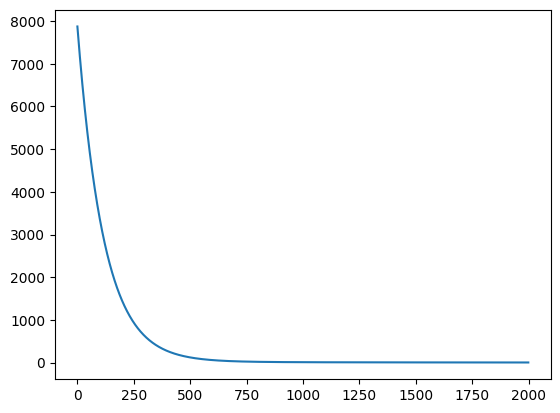

In [164]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights,1)
        self.w[5] = -100.
        self.w[9] = -100.
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w5, gradient_w9, eta=0.01):
        net.w[5] = net.w[5] - eta * gradient_w5
        net.w[9] = net.w[9] - eta * gradient_w9
        
    def train(self, x, y, iterations=100, eta=0.01):
        points = []
        losses = []
        for i in range(iterations):
            points.append([net.w[5][0], net.w[9][0]])
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            gradient_w5 = gradient_w[5][0]
            gradient_w9 = gradient_w[9][0]
            self.update(gradient_w5, gradient_w9, eta)
            losses.append(L)
            if i % 50 == 0:
                print('iter {}, point {}, loss {}'.format(i, [net.w[5][0], net.w[9][0]], L))
        return points, losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=2000
# 启动训练
points, losses = net.train(x, y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

#### 2.4.6 训练过程扩展到全部参数

为了能给读者直观的感受，上文演示的梯度下降的过程仅包含$w_5$和$w_9$两个参数。但房价预测的模型必须要对所有参数$w$和$b$进行求解，这需要将Network中的`update`和`train`函数进行修改。由于不再限定参与计算的参数（所有参数均参与计算），修改之后的代码反而更加简洁。

实现逻辑：“前向计算输出、根据输出和真实值计算Loss、基于Loss和输入计算梯度、根据梯度更新参数值”四个部分反复执行，直到到损失函数最小。

iter 9, loss 5.143394325795511
iter 19, loss 3.097924194225988
iter 29, loss 2.082241020617026
iter 39, loss 1.5673801618157397
iter 49, loss 1.296620473507743
iter 59, loss 1.1453399043319763
iter 69, loss 1.05301557174352
iter 79, loss 0.9902292156463155
iter 89, loss 0.9426576903842501
iter 99, loss 0.9033048096880771
iter 109, loss 0.8687320030413639
iter 119, loss 0.8372292509681438
iter 129, loss 0.8079274741612267
iter 139, loss 0.7803677341465795
iter 149, loss 0.7542920908532763
iter 159, loss 0.7295420168915829
iter 169, loss 0.7060090054240882
iter 179, loss 0.6836105084697764
iter 189, loss 0.6622781710179412
iter 199, loss 0.6419520361168634
iter 209, loss 0.6225776517869488
iter 219, loss 0.6041045903195836
iter 229, loss 0.5864856570315076
iter 239, loss 0.5696764374763877
iter 249, loss 0.5536350125932015
iter 259, loss 0.5383217588525027
iter 269, loss 0.5236991929680566
iter 279, loss 0.5097318413761649
iter 289, loss 0.4963861247069634
iter 299, loss 0.48363025234390

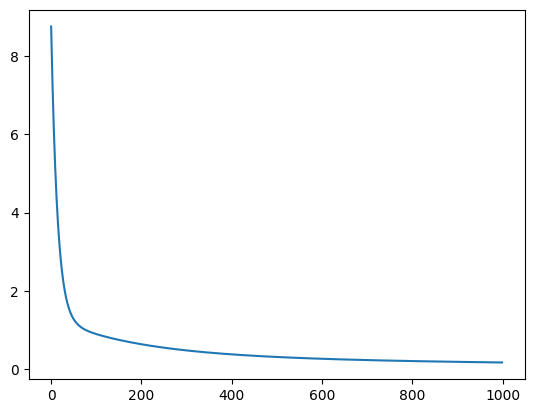

In [165]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

#### 2.4.7  随机梯度下降法（ Stochastic Gradient Descent）

在上述程序中，每次损失函数和梯度计算都是基于数据集中的全量数据。对于波士顿房价预测任务数据集而言，样本数比较少，只有404个。但在实际问题中，数据集往往非常大，如果每次都使用全量数据进行计算，效率非常低，通俗地说就是“杀鸡焉用牛刀”。由于参数每次只沿着梯度反方向更新一点点，因此方向并不需要那么精确。一个合理的解决方案是每次从总的数据集中随机抽取出小部分数据来代表整体，基于这部分数据计算梯度和损失来更新参数，这种方法被称作随机梯度下降法（Stochastic Gradient Descent，SGD），核心概念如下：

* mini-batch：每次迭代时抽取出来的一批数据被称为一个mini-batch。
* batch_size：一个mini-batch所包含的样本数目称为batch_size。
* epoch：当程序迭代的时候，按mini-batch逐渐抽取出样本，当把整个数据集都遍历到了的时候，则完成了一轮训练，也叫一个epoch。启动训练时，可以将训练的轮数num_epochs和batch_size作为参数传入。

下面结合程序介绍具体的实现过程，涉及到数据处理和训练过程两部分代码的修改。

**数据处理代码修改**

数据处理需要实现拆分数据批次和样本乱序（为了实现随机抽样的效果）两个功能。

In [166]:
# 获取数据
train_data, test_data = load_data()
train_data.shape

(404, 14)

In [167]:
# 1. train_data中一共包含404条数据，如果batch_size=10，即取前0-9号样本作为第一个mini-batch，命名train_data1。
train_data1 = train_data[0:10]
train_data1.shape

# 使用train_data1的数据（0-9号样本）计算梯度并更新网络参数。
net = Network(13)
x = train_data1[:, :-1]
y = train_data1[:, -1:]
loss = net.train(x, y, iterations=1, eta=0.01)
loss

[4.497480200683045]

In [168]:
# 再取出10-19号样本作为第二个mini-batch，计算梯度并更新网络参数。
train_data2 = train_data[10:20]
x = train_data2[:, :-1]
y = train_data2[:, -1:]
loss = net.train(x, y, iterations=1, eta=0.01)
loss

[5.849682302465981]

按此方法不断的取出新的mini-batch，并逐渐更新网络参数。

接下来，将train_data分成大小为batch_size的多个mini_batch，如下代码所示：将train_data分成 $\frac{404}{10} + 1 = 41$ 个 mini_batch，其中前40个mini_batch，每个均含有10个样本，
最后一个mini_batch只含有4个样本。

In [169]:
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]
print('total number of mini_batches is ', len(mini_batches))
print('first mini_batch shape ', mini_batches[0].shape)
print('last mini_batch shape ', mini_batches[-1].shape)

total number of mini_batches is  41
first mini_batch shape  (10, 14)
last mini_batch shape  (4, 14)


~~~~另外，这里是按顺序读取mini_batch，而SGD里面是随机抽取一部分样本代表总体。为了实现随机抽样的效果，我们先将train_data里面的样本顺序随机打乱，然后再抽取mini_batch。随机打乱样本顺序，需要用到`np.random.shuffle`函数，下面先介绍它的用法。

------
**说明：**

通过大量实验发现，模型受训练后期的影响更大，类似于人脑总是对近期发生的事情记忆的更加清晰。为了避免数据样本集合的顺序干扰模型的训练效果，需要进行样本乱序操作。当然，如果训练样本的顺序就是样本产生的顺序，而我们期望模型更重视近期产生的样本（预测样本会和近期的训练样本分布更接近），则不需要乱序这个步骤。

------

In [170]:
# 新建一个array
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
print('before shuffle', a)
np.random.shuffle(a)
print('after shuffle', a)

before shuffle [ 1  2  3  4  5  6  7  8  9 10 11 12]
after shuffle [ 7  2 11  3  8  6 12  1  4  5 10  9]


多次运行上面的代码，可以发现每次执行shuffle函数后的数字顺序均不同。
上面举的是一个1维数组乱序的案例，我们再观察下2维数组乱序后的效果。

In [171]:
# 新建一个array
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
a = a.reshape([6, 2])
print('before shuffle\n', a)
np.random.shuffle(a)
print('after shuffle\n', a)

before shuffle
 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
after shuffle
 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 9 10]
 [11 12]
 [ 7  8]]


观察运行结果可发现，数组的元素在第0维被随机打乱，但第1维的顺序保持不变。例如数字2仍然紧挨在数字1的后面，数字8仍然紧挨在数字7的后面，而第二维的[3, 4]并不排在[1, 2]的后面。将这部分实现SGD算法的代码集成到Network类中的`train`函数中，最终的完整代码如下。

In [172]:
# 获取数据
train_data, test_data = load_data()

# 打乱样本顺序
np.random.shuffle(train_data)

# 将train_data分成多个mini_batch
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]

# 创建网络
net = Network(13)

# 依次使用每个mini_batch的数据
for mini_batch in mini_batches:
    x = mini_batch[:, :-1]
    y = mini_batch[:, -1:]
    loss = net.train(x, y, iterations=1)

*  **训练过程代码修改**

将每个随机抽取的mini-batch数据输入到模型中用于参数训练。训练过程的核心是两层循环：

1. 第一层循环，代表样本集合要被训练遍历几次，称为“epoch”，代码如下：

`for epoch_id in range(num_epochs):`

2. 第二层循环，代表每次遍历时，样本集合被拆分成的多个批次，需要全部执行训练，称为“iter (iteration)”，代码如下：

`for iter_id,mini_batch in emumerate(mini_batches):`

在两层循环的内部是经典的四步训练流程：前向计算->计算损失->计算梯度->更新参数，这与大家之前所学是一致的，代码如下：

                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)  #前向计算
                loss = self.loss(a, y)  #计算损失
                gradient_w, gradient_b = self.gradient(x, y)  #计算梯度
                self.update(gradient_w, gradient_b, eta)  #更新参数


将两部分改写的代码集成到Network类中的`train`函数中，最终的实现如下。

Epoch   0 / iter   0, loss = 1.0281
Epoch   0 / iter   1, loss = 0.5048
Epoch   0 / iter   2, loss = 0.6382
Epoch   0 / iter   3, loss = 0.5168
Epoch   0 / iter   4, loss = 0.1951
Epoch   1 / iter   0, loss = 0.6281
Epoch   1 / iter   1, loss = 0.4611
Epoch   1 / iter   2, loss = 0.4520
Epoch   1 / iter   3, loss = 0.3961
Epoch   1 / iter   4, loss = 0.1381
Epoch   2 / iter   0, loss = 0.5642
Epoch   2 / iter   1, loss = 0.4250
Epoch   2 / iter   2, loss = 0.4480
Epoch   2 / iter   3, loss = 0.3881
Epoch   2 / iter   4, loss = 0.1884
Epoch   3 / iter   0, loss = 0.3921
Epoch   3 / iter   1, loss = 0.5582
Epoch   3 / iter   2, loss = 0.3759
Epoch   3 / iter   3, loss = 0.3849
Epoch   3 / iter   4, loss = 0.1425
Epoch   4 / iter   0, loss = 0.3821
Epoch   4 / iter   1, loss = 0.4382
Epoch   4 / iter   2, loss = 0.3864
Epoch   4 / iter   3, loss = 0.4314
Epoch   4 / iter   4, loss = 0.0471
Epoch   5 / iter   0, loss = 0.4264
Epoch   5 / iter   1, loss = 0.3829
Epoch   5 / iter   2, loss =

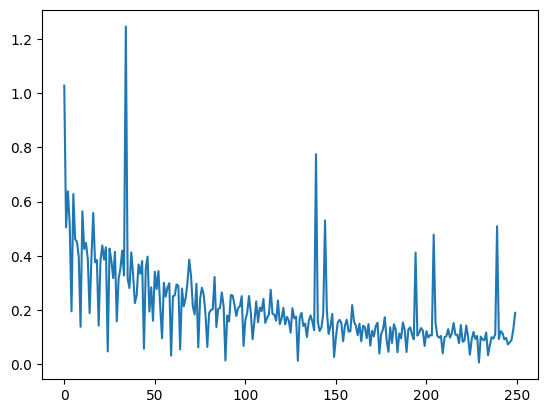

In [173]:
import numpy as np

class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z-y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z-y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

观察上述Loss的变化，随机梯度下降加快了训练过程，但由于每次仅基于少量样本更新参数和计算损失，所以损失下降曲线会出现震荡。

------
**说明：**

由于房价预测的数据量过少，所以难以感受到随机梯度下降带来的性能提升。

------

### 2.5 模型保存
Numpy提供了save接口，可直接将模型权重数组保存为.npy格式的文件。

In [ ]:
np.save('w.npy', net.w)
np.save('b.npy', net.b)